In [60]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action = 'ignore')

In [61]:
# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

In [62]:
df_good = pd.read_csv('./dataset/data_확장기.csv')
df_bad = pd.read_csv('./dataset/data_수축기.csv')
df_change = pd.read_csv('./dataset/data_전환기.csv')
df_all = pd.read_csv('./dataset/data_전체.csv')

df_good.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_bad.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_change.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_all.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)

#### 함수

##### train, test 분리, 데이터 불균형 처리, 스케일링

In [63]:
def data(df):
    # scaler : StandardScaler(), RobustScaler()

    features = df.drop(['target'], axis=1)
    target = df['target']

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    
    # X_train, y_train = RandomUnderSampler(random_state=121).fit_resample(X_train, y_train)
    X_train, y_train = TomekLinks(sampling_strategy = 'not majority').fit_resample(X_train, y_train) # not majority(Good), majority, all
    # X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)

    # X_train, y_train = BorderlineSMOTE(random_state=121, sampling_strategy = 'not majority').fit_resample(X_train, y_train)
    # X_train, y_train = ADASYN(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state=121).fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [64]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [65]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### 모델링

In [66]:
def LR(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()

    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

In [67]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [68]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

In [69]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

#### Feature Selection

In [70]:
rfe_good = df_good[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '유형자산증가율', '순이익증가율', 'target']]
sfm_rf_good = df_good[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_good = df_good[['자기자본비율', '차입금의존도', '총자산이익률', '총자본경상이익률', '자기자본영업이익률', '매출원가율', '총자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_good = df_good[['자기자본영업이익률', '총자본회전율', '총자산이익률', '총자본경상이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

In [71]:
rfe_bad = df_bad[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', 'target']]
sfm_rf_bad = df_bad[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_bad = df_bad[['자기자본비율', '유동비율', '차입금의존도', '자기자본영업이익률', '매출원가율', '총자본회전율', '자기자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_bad = df_bad[['자기자본영업이익률', '총자본회전율', '총자본경상이익률', '총자산이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

#### 확장기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.38145128133664763

예측 데이터 정확도
accuracy score : 0.812
precision score : 0.342
recall score : 0.843
f1 score : 0.487
roc score : 0.826
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.60298    0.20583 0.96550   0.33932    0.76284
0.30000   0.69824    0.25147 0.93977   0.39677    0.80475
0.40000   0.76602    0.29762 0.89398   0.44657    0.82244
0.50000   0.81226    0.34216 0.84316   0.48678    0.82588
0.60000   0.84690    0.38557 0.75784   0.51111    0.80763
0.70000   0.86658    0.41272 0.62296   0.49650    0.75915
0.80000   0.87486    0.41225 0.43476   0.42321    0.68079
0.90000   0.87698    0.36201 0.21644   0.27091    0.58570
None


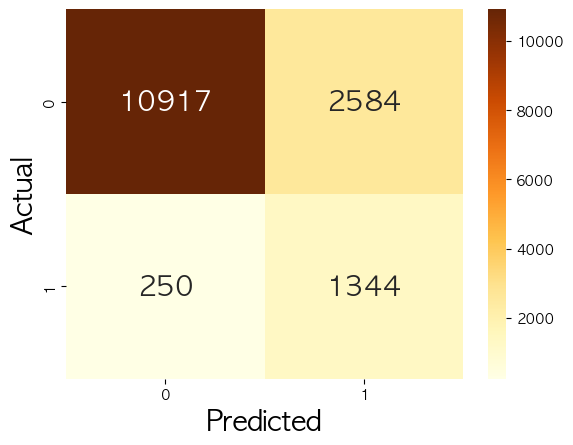

In [72]:
LR(rfe_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.472356286926449

예측 데이터 정확도
accuracy score : 0.868
precision score : 0.440
recall score : 0.936
f1 score : 0.599
roc score : 0.898
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81981    0.36833 0.98808   0.53663    0.89401
0.30000   0.83451    0.38767 0.97867   0.55536    0.89808
0.40000   0.85247    0.41388 0.95420   0.57734    0.89733
0.50000   0.86764    0.44038 0.93601   0.59896    0.89779
0.60000   0.87963    0.46452 0.91593   0.61642    0.89564
0.70000   0.88745    0.48225 0.89460   0.62668    0.89060
0.80000   0.90692    0.54020 0.79674   0.64385    0.85833
0.90000   0.91706    0.62648 0.53137   0.57502    0.74698
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

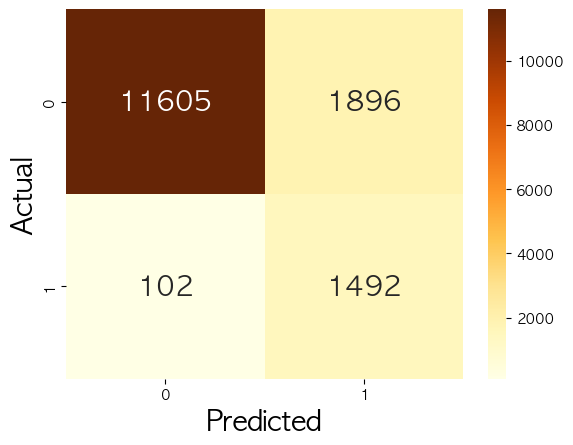

In [73]:
DT(rfe_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.46589766854058895

예측 데이터 정확도
accuracy score : 0.877
precision score : 0.453
recall score : 0.782
f1 score : 0.574
roc score : 0.835


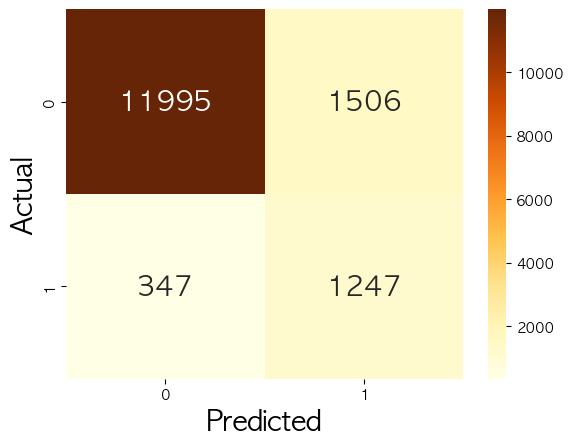

In [74]:
SVM(rfe_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.558033876566061

예측 데이터 정확도
accuracy score : 0.912
precision score : 0.560
recall score : 0.760
f1 score : 0.645
roc score : 0.845
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.88049    0.46692 0.92974   0.62164    0.90221
0.30000   0.89652    0.50577 0.88018   0.64240    0.88931
0.40000   0.90580    0.53522 0.81995   0.64767    0.86794
0.50000   0.91163    0.56013 0.75972   0.64483    0.84464
0.60000   0.91540    0.58714 0.67001   0.62584    0.80719
0.70000   0.91779    0.62215 0.56399   0.59164    0.76177
0.80000   0.91759    0.66925 0.43413   0.52664    0.70440
0.90000   0.90944    0.73306 0.22396   0.34310    0.60717
None


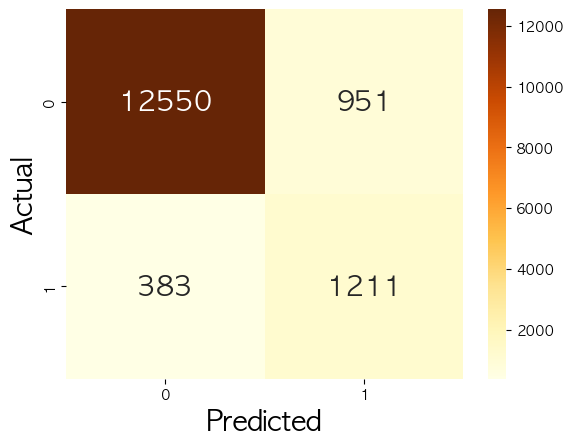

In [75]:
XGB(rfe_good)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.39953767656215466

예측 데이터 정확도
accuracy score : 0.817
precision score : 0.350
recall score : 0.856
f1 score : 0.497
roc score : 0.834
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.61100    0.20890 0.96299   0.34332    0.76621
0.30000   0.70010    0.25274 0.94040   0.39841    0.80606
0.40000   0.77026    0.30356 0.90841   0.45506    0.83118
0.50000   0.81663    0.34964 0.85634   0.49654    0.83414
0.60000   0.85154    0.39541 0.76725   0.52187    0.81437
0.70000   0.86916    0.41904 0.61857   0.49962    0.75866
0.80000   0.87453    0.41124 0.43601   0.42326    0.68116
0.90000   0.88109    0.39859 0.24780   0.30561    0.60183
None


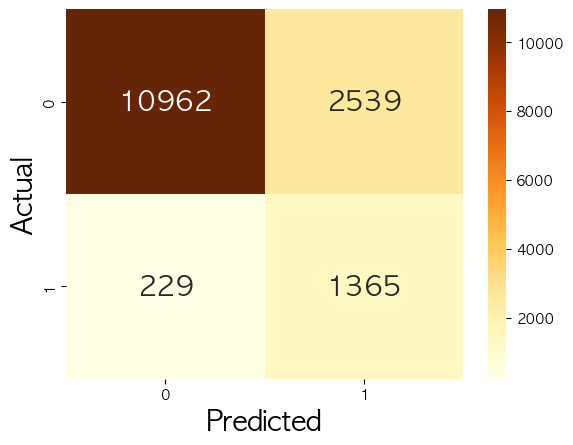

In [76]:
LR(sfm_rf_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.49446003743251027

예측 데이터 정확도
accuracy score : 0.858
precision score : 0.424
recall score : 0.949
f1 score : 0.586
roc score : 0.898
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81795    0.36625 0.99122   0.53487    0.89436
0.30000   0.84531    0.40237 0.95797   0.56671    0.89499
0.40000   0.85816    0.42350 0.94981   0.58580    0.89858
0.50000   0.85850    0.42400 0.94856   0.58605    0.89821
0.60000   0.87837    0.46190 0.92033   0.61509    0.89687
0.70000   0.89314    0.49663 0.87767   0.63432    0.88632
0.80000   0.90633    0.53883 0.78356   0.63855    0.85219
0.90000   0.91600    0.61149 0.56085   0.58508    0.75939
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

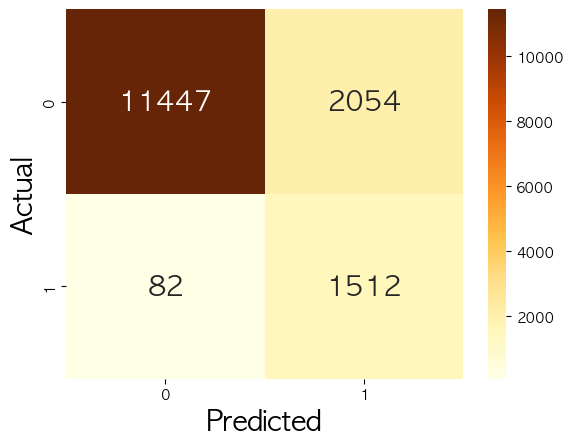

In [77]:
DT(sfm_rf_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.49566138264904225

예측 데이터 정확도
accuracy score : 0.879
precision score : 0.460
recall score : 0.814
f1 score : 0.588
roc score : 0.850


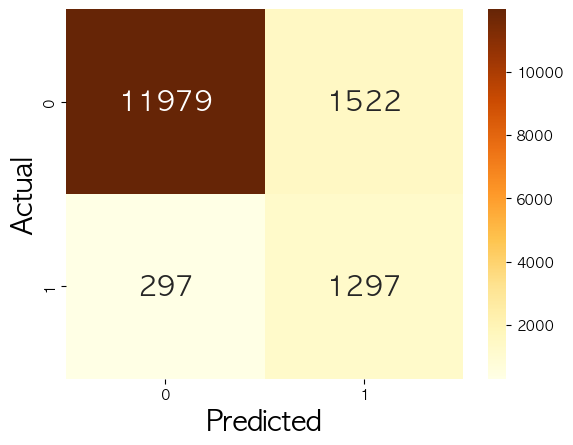

In [78]:
SVM(sfm_rf_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.5725989224449373

예측 데이터 정확도
accuracy score : 0.909
precision score : 0.551
recall score : 0.748
f1 score : 0.635
roc score : 0.838
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.88122    0.46789 0.90966   0.61794    0.89376
0.30000   0.89367    0.49802 0.86763   0.63281    0.88219
0.40000   0.90255    0.52487 0.81430   0.63831    0.86364
0.50000   0.90904    0.55109 0.74780   0.63455    0.83794
0.60000   0.91388    0.57770 0.68570   0.62708    0.81326
0.70000   0.91759    0.61589 0.58344   0.59923    0.77024
0.80000   0.91719    0.66412 0.43664   0.52687    0.70528
0.90000   0.91050    0.74447 0.23212   0.35390    0.61136
None


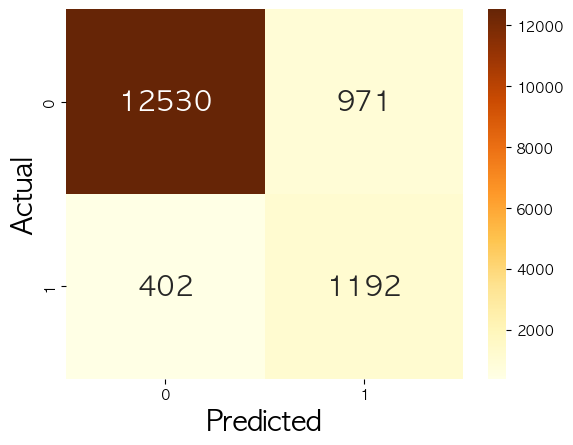

In [79]:
XGB(sfm_rf_good)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.4139497234955992

예측 데이터 정확도
accuracy score : 0.802
precision score : 0.327
recall score : 0.826
f1 score : 0.468
roc score : 0.813
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.58039    0.19755 0.97114   0.32831    0.75270
0.30000   0.68851    0.24525 0.93852   0.38887    0.79875
0.40000   0.75727    0.28963 0.89398   0.43752    0.81755
0.50000   0.80192    0.32680 0.82622   0.46835    0.81264
0.60000   0.83836    0.36781 0.73839   0.49103    0.79428
0.70000   0.86148    0.39861 0.61292   0.48307    0.75187
0.80000   0.86996    0.39733 0.44793   0.42111    0.68386
0.90000   0.87671    0.36021 0.21581   0.26991    0.58528
None


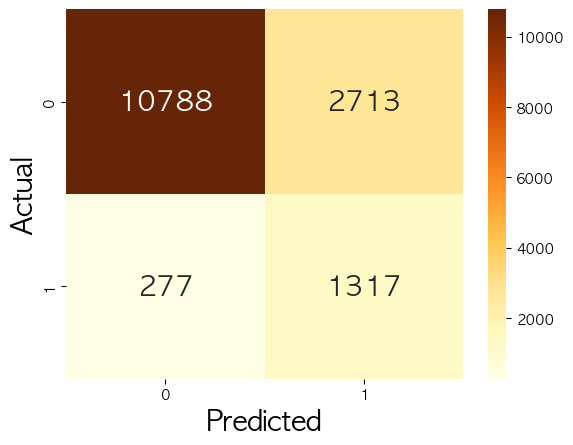

In [80]:
LR(sfm_lr_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.4798037008928936

예측 데이터 정확도
accuracy score : 0.841
precision score : 0.395
recall score : 0.945
f1 score : 0.557
roc score : 0.887
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81192    0.35862 0.99059   0.52660    0.89071
0.30000   0.81192    0.35862 0.99059   0.52660    0.89071
0.40000   0.81298    0.35974 0.98871   0.52753    0.89047
0.50000   0.84107    0.39461 0.94542   0.55681    0.88709
0.60000   0.85075    0.40829 0.92033   0.56564    0.88143
0.70000   0.88082    0.46415 0.83250   0.59600    0.85951
0.80000   0.90268    0.52963 0.70075   0.60329    0.81364
0.90000   0.91381    0.67256 0.35822   0.46746    0.66881
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

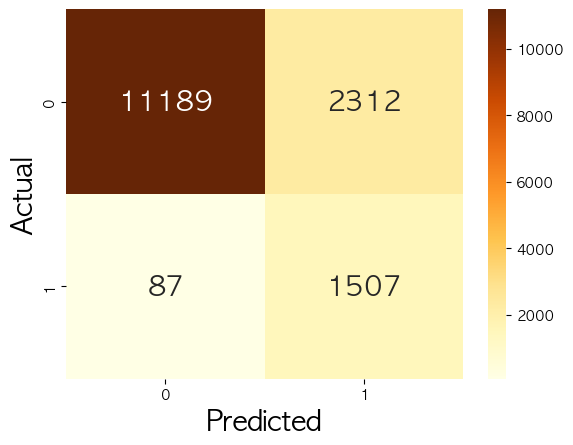

In [81]:
DT(sfm_lr_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.5090659935190297

예측 데이터 정확도
accuracy score : 0.874
precision score : 0.442
recall score : 0.727
f1 score : 0.550
roc score : 0.809


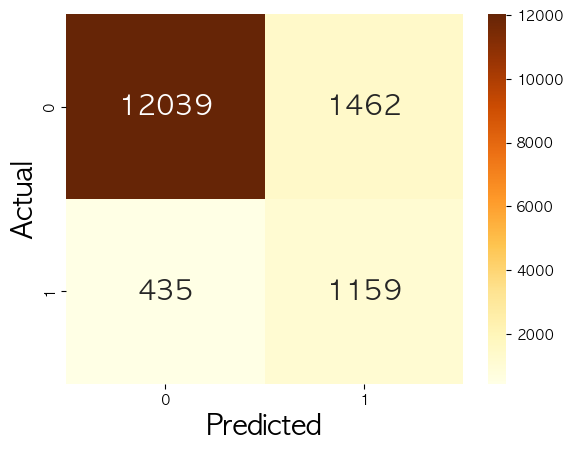

In [82]:
SVM(sfm_lr_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.5810631302147005

예측 데이터 정확도
accuracy score : 0.901
precision score : 0.522
recall score : 0.744
f1 score : 0.614
roc score : 0.832
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.85631    0.41876 0.92974   0.57744    0.88869
0.30000   0.87645    0.45576 0.87578   0.59953    0.87616
0.40000   0.88963    0.48644 0.80991   0.60782    0.85448
0.50000   0.90103    0.52201 0.74404   0.61355    0.83180
0.60000   0.90964    0.56040 0.66939   0.61006    0.80369
0.70000   0.91593    0.60518 0.58657   0.59573    0.77070
0.80000   0.91832    0.66394 0.45859   0.54249    0.71559
0.90000   0.91342    0.74281 0.27541   0.40183    0.63207
None


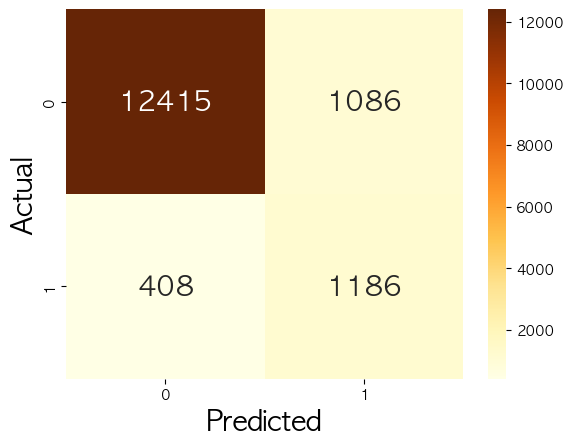

In [83]:
XGB(sfm_lr_good)

##### Permutation Importance

최적 파라미터
 {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.38213562850722155

예측 데이터 정확도
accuracy score : 0.814
precision score : 0.344
recall score : 0.839
f1 score : 0.488
roc score : 0.825
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.60510    0.20656 0.96424   0.34023    0.76347
0.30000   0.70063    0.25283 0.93852   0.39835    0.80553
0.40000   0.76714    0.29876 0.89460   0.44793    0.82335
0.50000   0.81391    0.34387 0.83940   0.48788    0.82515
0.60000   0.84810    0.38794 0.75910   0.51347    0.80885
0.70000   0.86645    0.41082 0.60979   0.49091    0.75327
0.80000   0.87459    0.41170 0.43726   0.42409    0.68175
0.90000   0.87791    0.37098 0.22459   0.27980    0.58982
None


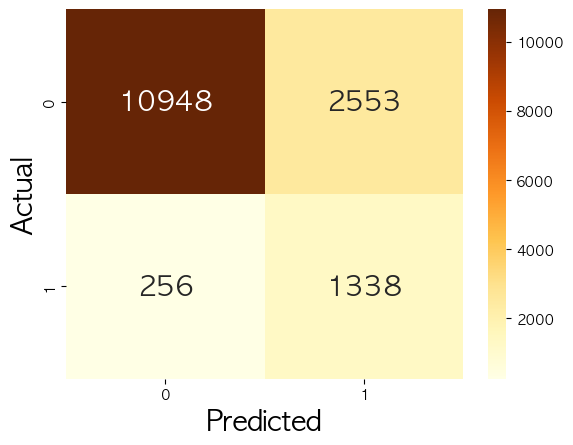

In [84]:
LR(sfm_pi_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.4777620993983712

예측 데이터 정확도
accuracy score : 0.868
precision score : 0.441
recall score : 0.934
f1 score : 0.599
roc score : 0.897
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81729    0.36459 0.98306   0.53191    0.89039
0.30000   0.83803    0.39198 0.96863   0.55811    0.89562
0.40000   0.85578    0.41914 0.94793   0.58127    0.89642
0.50000   0.86804    0.44102 0.93350   0.59903    0.89690
0.60000   0.87519    0.45514 0.92284   0.60961    0.89620
0.70000   0.89294    0.49612 0.88331   0.63538    0.88870
0.80000   0.90600    0.53687 0.79925   0.64230    0.85892
0.90000   0.91620    0.62664 0.51066   0.56274    0.73737
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

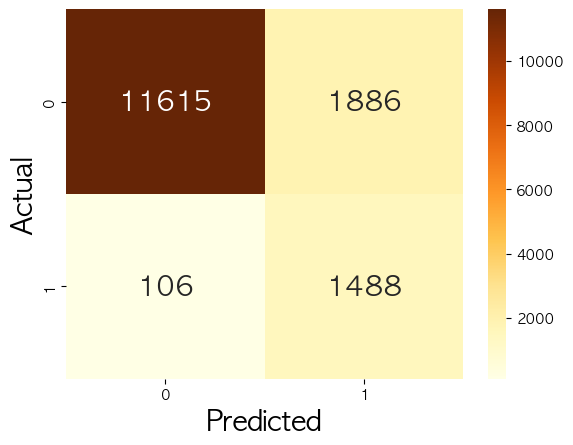

In [85]:
DT(sfm_pi_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.46829897906816986

예측 데이터 정확도
accuracy score : 0.870
precision score : 0.439
recall score : 0.831
f1 score : 0.574
roc score : 0.853


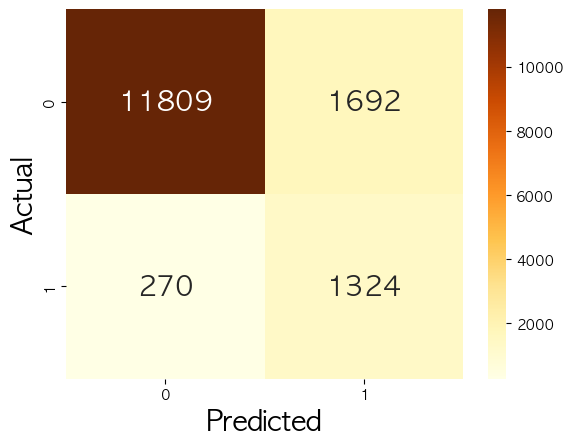

In [86]:
SVM(sfm_pi_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.5592416804072265

예측 데이터 정확도
accuracy score : 0.912
precision score : 0.561
recall score : 0.758
f1 score : 0.645
roc score : 0.844
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.88148    0.46862 0.91343   0.61944    0.89557
0.30000   0.89632    0.50528 0.87014   0.63932    0.88478
0.40000   0.90540    0.53393 0.81932   0.64653    0.86744
0.50000   0.91189    0.56134 0.75784   0.64495    0.84396
0.60000   0.91500    0.58383 0.67942   0.62801    0.81112
0.70000   0.91852    0.62182 0.58281   0.60168    0.77048
0.80000   0.91626    0.65684 0.43350   0.52230    0.70338
0.90000   0.90997    0.73453 0.23087   0.35131    0.61051
None


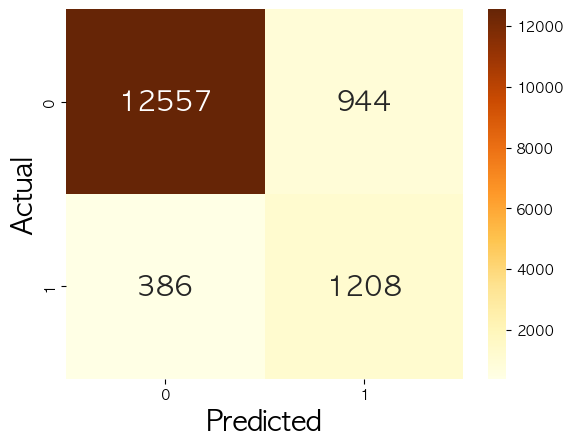

In [87]:
XGB(sfm_pi_good)

#### 수축기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.28070894382194655

예측 데이터 정확도
accuracy score : 0.791
precision score : 0.271
recall score : 0.867
f1 score : 0.413
roc score : 0.825
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.54196    0.15389 0.97479   0.26581    0.73825
0.30000   0.65661    0.19279 0.95294   0.32070    0.79100
0.40000   0.73524    0.23425 0.93109   0.37432    0.82406
0.50000   0.79056    0.27129 0.86723   0.41330    0.82533
0.60000   0.82902    0.29900 0.75126   0.42775    0.79376
0.70000   0.85418    0.29972 0.53445   0.38406    0.70918
0.80000   0.87420    0.29844 0.35462   0.32412    0.63856
0.90000   0.88678    0.23592 0.14790   0.18182    0.55168
None


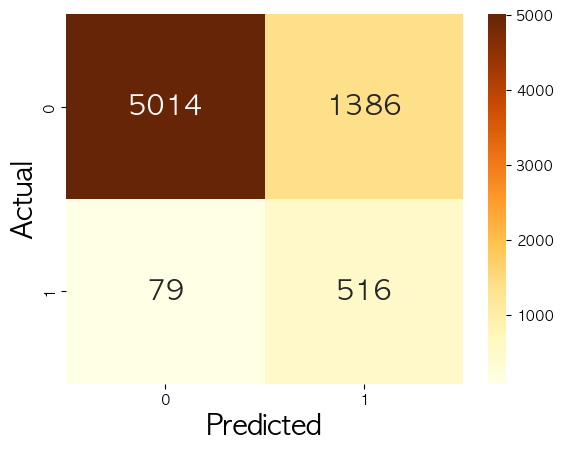

In [88]:
LR(rfe_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.30607838287738015

예측 데이터 정확도
accuracy score : 0.805
precision score : 0.293
recall score : 0.914
f1 score : 0.444
roc score : 0.855
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.78313    0.27708 0.96303   0.43034    0.86472
0.30000   0.78313    0.27708 0.96303   0.43034    0.86472
0.40000   0.78342    0.27648 0.95630   0.42895    0.86182
0.50000   0.80515    0.29310 0.91429   0.44390    0.85464
0.60000   0.80558    0.29291 0.90924   0.44308    0.85259
0.70000   0.88578    0.39841 0.67227   0.50031    0.78895
0.80000   0.90593    0.46008 0.61008   0.52457    0.77176
0.90000   0.92037    0.56090 0.29412   0.38589    0.63636
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

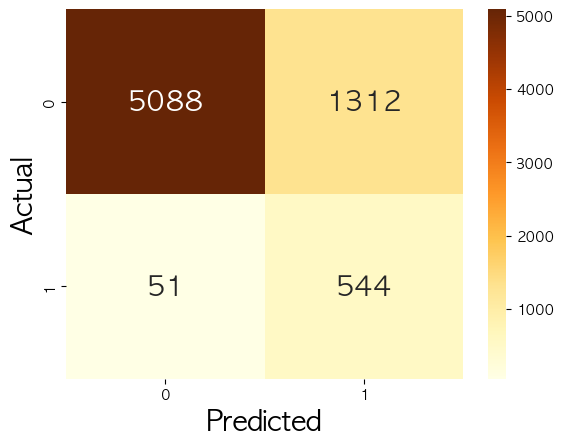

In [89]:
DT(rfe_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 10.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.3687598277180697

예측 데이터 정확도
accuracy score : 0.906
precision score : 0.443
recall score : 0.405
f1 score : 0.423
roc score : 0.679


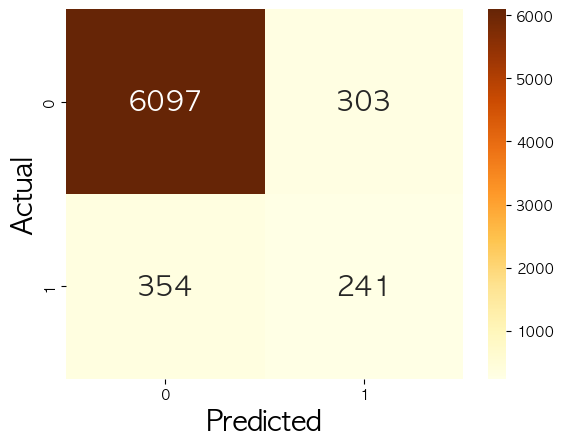

In [90]:
SVM(rfe_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.431019021793961

예측 데이터 정확도
accuracy score : 0.904
precision score : 0.454
recall score : 0.620
f1 score : 0.524
roc score : 0.775
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.83474    0.32523 0.87731   0.47455    0.85405
0.30000   0.86533    0.36561 0.79328   0.50053    0.83265
0.40000   0.88578    0.40211 0.70420   0.51191    0.80343
0.50000   0.90422    0.45387 0.62017   0.52415    0.77540
0.60000   0.91665    0.50977 0.52605   0.51778    0.73951
0.70000   0.91966    0.53659 0.40672   0.46272    0.68703
0.80000   0.92309    0.59930 0.28908   0.39002    0.63555
0.90000   0.92137    0.71845 0.12437   0.21203    0.55992
None


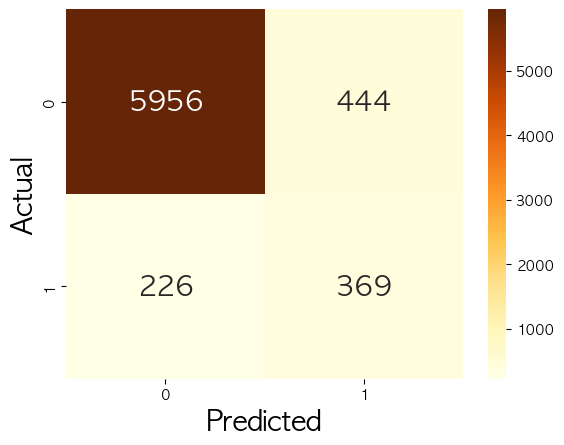

In [91]:
XGB(rfe_bad)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.30873393410100103

예측 데이터 정확도
accuracy score : 0.806
precision score : 0.288
recall score : 0.872
f1 score : 0.433
roc score : 0.836
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.57141    0.16241 0.97143   0.27829    0.75282
0.30000   0.67248    0.19929 0.94454   0.32914    0.79586
0.40000   0.75011    0.24344 0.91933   0.38494    0.82685
0.50000   0.80558    0.28785 0.87227   0.43286    0.83582
0.60000   0.84060    0.31818 0.76471   0.44938    0.80618
0.70000   0.86405    0.33519 0.60840   0.43224    0.74811
0.80000   0.87648    0.32043 0.40336   0.35714    0.66192
0.90000   0.89021    0.29356 0.20672   0.24260    0.58024
None


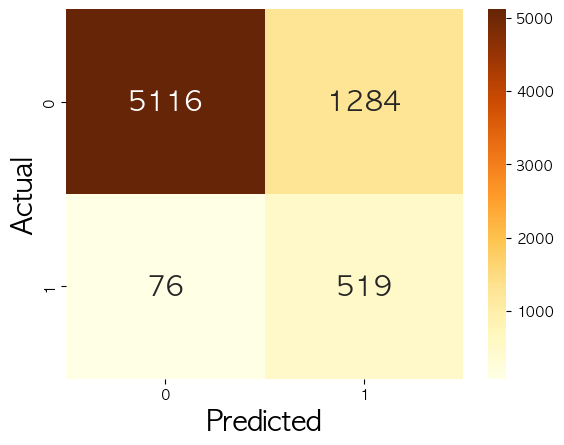

In [92]:
LR(sfm_rf_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.3633400674821249

예측 데이터 정확도
accuracy score : 0.846
precision score : 0.344
recall score : 0.886
f1 score : 0.495
roc score : 0.864
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.78256    0.27952 0.98655   0.43562    0.87507
0.30000   0.78513    0.28068 0.97647   0.43602    0.87191
0.40000   0.79643    0.29013 0.96303   0.44591    0.87198
0.50000   0.84646    0.34377 0.88571   0.49530    0.86426
0.60000   0.84646    0.34377 0.88571   0.49530    0.86426
0.70000   0.86948    0.38009 0.84706   0.52473    0.85931
0.80000   0.89578    0.43393 0.73950   0.54692    0.82490
0.90000   0.91808    0.53274 0.30084   0.38453    0.63815
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

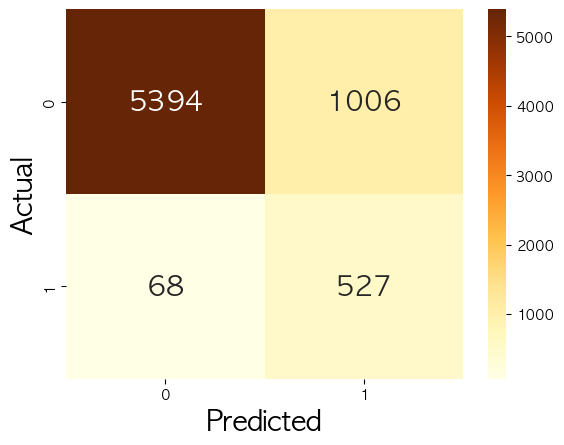

In [93]:
DT(sfm_rf_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.3885460662637541

예측 데이터 정확도
accuracy score : 0.883
precision score : 0.396
recall score : 0.701
f1 score : 0.506
roc score : 0.801


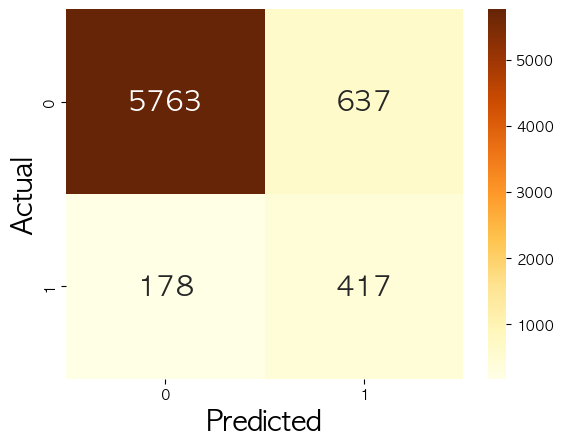

In [94]:
SVM(sfm_rf_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.45578249216837

예측 데이터 정확도
accuracy score : 0.903
precision score : 0.452
recall score : 0.672
f1 score : 0.541
roc score : 0.798
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.85904    0.36582 0.89580   0.51949    0.87571
0.30000   0.87791    0.39615 0.83025   0.53637    0.85630
0.40000   0.89292    0.42708 0.75798   0.54634    0.83173
0.50000   0.90293    0.45249 0.67227   0.54091    0.79832
0.60000   0.91265    0.48867 0.57983   0.53036    0.76171
0.70000   0.91923    0.52863 0.46555   0.49508    0.71348
0.80000   0.92466    0.60625 0.32605   0.42404    0.65318
0.90000   0.92252    0.70866 0.15126   0.24931    0.57274
None


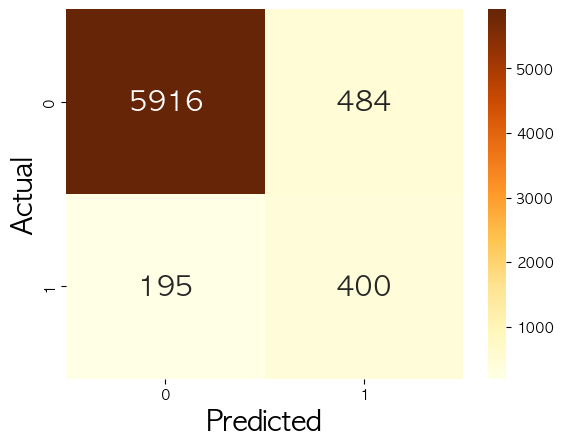

In [95]:
XGB(sfm_rf_bad)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.3407986001881661

예측 데이터 정확도
accuracy score : 0.795
precision score : 0.268
recall score : 0.810
f1 score : 0.403
roc score : 0.802
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.55182    0.15676 0.97479   0.27008    0.74364
0.30000   0.67477    0.20107 0.94958   0.33186    0.79940
0.40000   0.75354    0.24376 0.90252   0.38385    0.82110
0.50000   0.79543    0.26778 0.81008   0.40251    0.80207
0.60000   0.82788    0.28780 0.69412   0.40690    0.76722
0.70000   0.85089    0.30000 0.56471   0.39184    0.72110
0.80000   0.86605    0.29739 0.42185   0.34885    0.66460
0.90000   0.88320    0.21970 0.14622   0.17558    0.54897
None


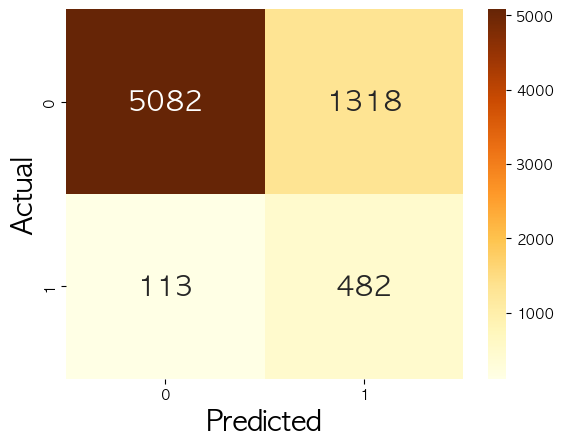

In [96]:
LR(sfm_lr_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.37661618749736536

예측 데이터 정확도
accuracy score : 0.800
precision score : 0.292
recall score : 0.953
f1 score : 0.448
roc score : 0.869
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.77141    0.26972 0.98824   0.42378    0.86974
0.30000   0.77141    0.26972 0.98824   0.42378    0.86974
0.40000   0.79543    0.28825 0.95630   0.44297    0.86839
0.50000   0.79986    0.29242 0.95294   0.44751    0.86928
0.60000   0.79986    0.29242 0.95294   0.44751    0.86928
0.70000   0.87863    0.38957 0.75294   0.51347    0.82163
0.80000   0.90122    0.44299 0.62689   0.51914    0.77680
0.90000   0.92094    0.59375 0.22353   0.32479    0.60466
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

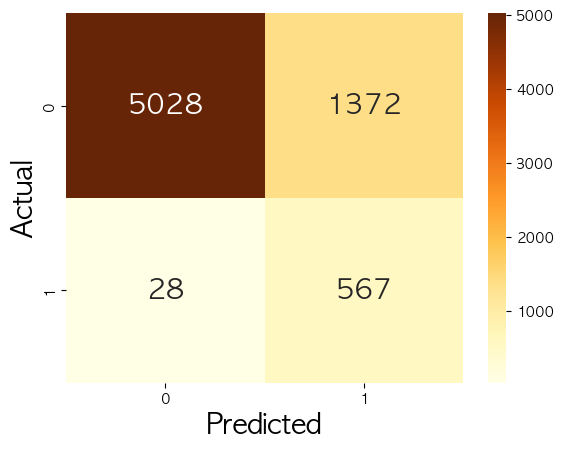

In [97]:
DT(sfm_lr_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.4271490838465806

예측 데이터 정확도
accuracy score : 0.879
precision score : 0.368
recall score : 0.595
f1 score : 0.455
roc score : 0.750


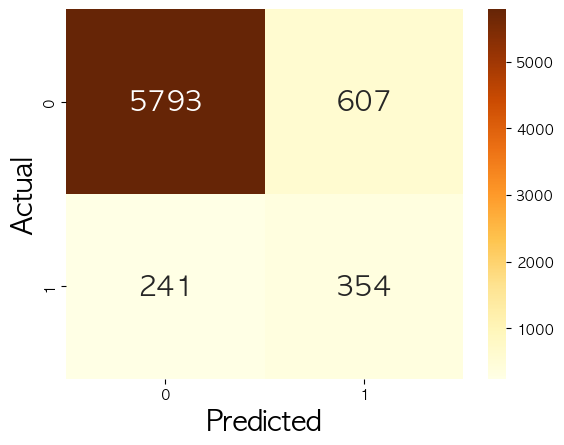

In [98]:
SVM(sfm_lr_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.6, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.48991832067678187

예측 데이터 정확도
accuracy score : 0.906
precision score : 0.458
recall score : 0.545
f1 score : 0.497
roc score : 0.742
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.85961    0.35506 0.79664   0.49119    0.83105
0.30000   0.87991    0.38813 0.71429   0.50296    0.80480
0.40000   0.89607    0.42483 0.62689   0.50645    0.77399
0.50000   0.90636    0.45763 0.54454   0.49731    0.74227
0.60000   0.91623    0.50785 0.48908   0.49829    0.72251
0.70000   0.92066    0.54545 0.40336   0.46377    0.68606
0.80000   0.92352    0.59868 0.30588   0.40489    0.64341
0.90000   0.92266    0.65169 0.19496   0.30013    0.59264
None


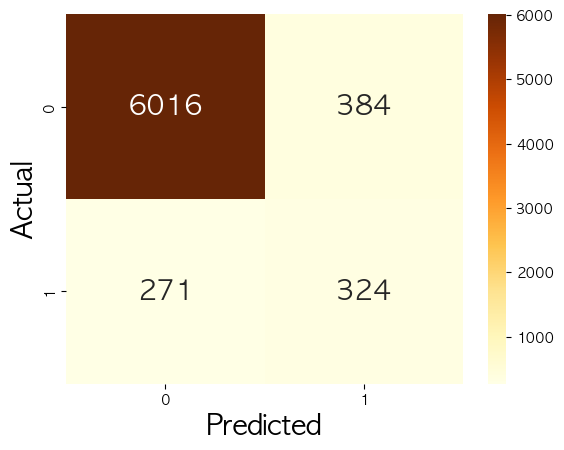

In [99]:
XGB(sfm_lr_bad)

##### Permutation Importance

최적 파라미터
 {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.2928143942669889

예측 데이터 정확도
accuracy score : 0.798
precision score : 0.277
recall score : 0.859
f1 score : 0.419
roc score : 0.825
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.55096    0.15669 0.97647   0.27004    0.74394
0.30000   0.66162    0.19511 0.95294   0.32391    0.79374
0.40000   0.74081    0.23682 0.92101   0.37676    0.82254
0.50000   0.79757    0.27727 0.85882   0.41920    0.82535
0.60000   0.83574    0.31001 0.75966   0.44033    0.80124
0.70000   0.86004    0.32353 0.59160   0.41830    0.73830
0.80000   0.87563    0.31087 0.37983   0.34191    0.65078
0.90000   0.88749    0.26355 0.17983   0.21379    0.56656
None


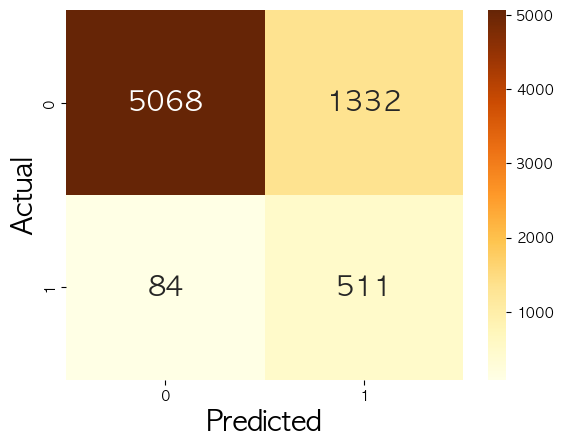

In [100]:
LR(sfm_pi_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.36097033106781035

예측 데이터 정확도
accuracy score : 0.855
precision score : 0.359
recall score : 0.897
f1 score : 0.513
roc score : 0.874
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.78942    0.28159 0.95126   0.43455    0.86282
0.30000   0.79800    0.28983 0.94790   0.44392    0.86598
0.40000   0.79800    0.28983 0.94790   0.44392    0.86598
0.50000   0.85518    0.35935 0.89748   0.51321    0.87436
0.60000   0.85518    0.35935 0.89748   0.51321    0.87436
0.70000   0.86676    0.37834 0.88067   0.52929    0.87307
0.80000   0.90007    0.44235 0.67059   0.53307    0.79600
0.90000   0.92152    0.55157 0.41345   0.47262    0.69110
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

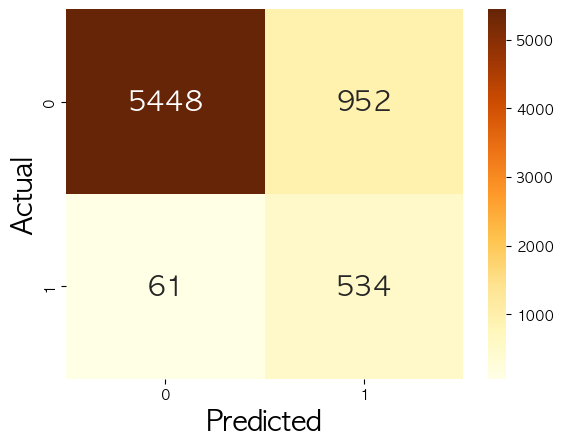

In [101]:
DT(sfm_pi_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.375669006677083

예측 데이터 정확도
accuracy score : 0.869
precision score : 0.363
recall score : 0.721
f1 score : 0.483
roc score : 0.802


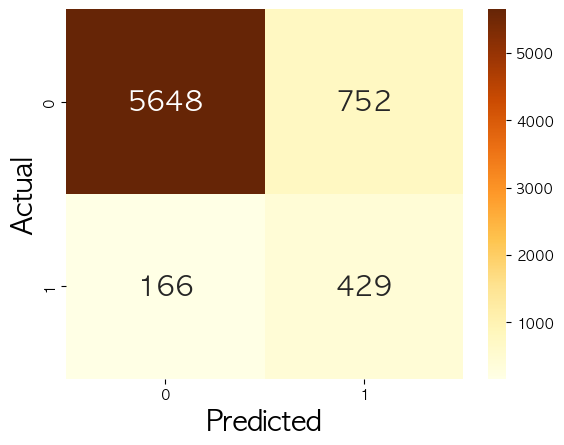

In [102]:
SVM(sfm_pi_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.45902254522526187

예측 데이터 정확도
accuracy score : 0.907
precision score : 0.467
recall score : 0.669
f1 score : 0.550
roc score : 0.799
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.86219    0.37016 0.88403   0.52183    0.87209
0.30000   0.88020    0.39934 0.81008   0.53496    0.84840
0.40000   0.89335    0.42634 0.73445   0.53951    0.82129
0.50000   0.90693    0.46714 0.66891   0.55010    0.79899
0.60000   0.91894    0.52077 0.58992   0.55319    0.76972
0.70000   0.92395    0.56415 0.46555   0.51013    0.71605
0.80000   0.92509    0.61415 0.32101   0.42163    0.65113
0.90000   0.92152    0.68254 0.14454   0.23856    0.56914
None


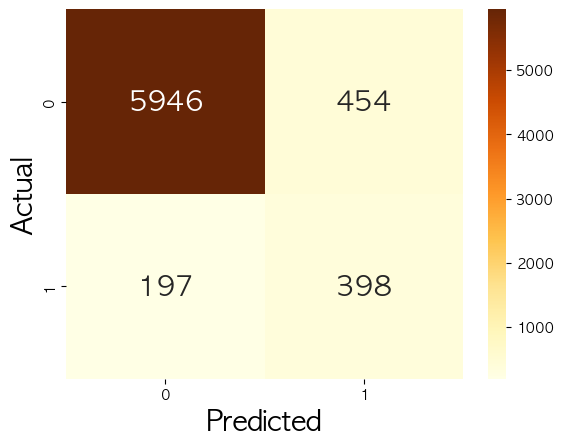

In [103]:
XGB(sfm_pi_bad)